In [74]:
from qecsim.models.rotatedplanar import RotatedPlanarCode
import stim
import jax.numpy as jnp
from jax import random
from concurrent.futures import ProcessPoolExecutor
from src.circuit_builder import prepare_circuit_info, build_stim_circuit

key = random.key(0)

In [175]:
distance = 3
code = RotatedPlanarCode(distance, distance)
subkey, key = random.split(key)
deformation = random.randint(subkey, (distance**2,), 0, 6, dtype=jnp.int8)
basis_z = True # Prepare and measure in the Z basis (alternative is X basis)

In [176]:
stabilizers, logicals, syndrome_loc, data_loc, connection_order = prepare_circuit_info(code, deformation)
num_dat = len(data_loc)
num_syn = len(syndrome_loc)

In [313]:
basis = ["XYXZZY", "ZZYXYX"]
stab_gates = [
    [
        "NONE", # (0,0) SHOULD NEVER HAPPEN
        "CZ"    # (0,1)
    ], [
        "CX",   # (1,0)
        "CY"    # (1,1)
    ]
]

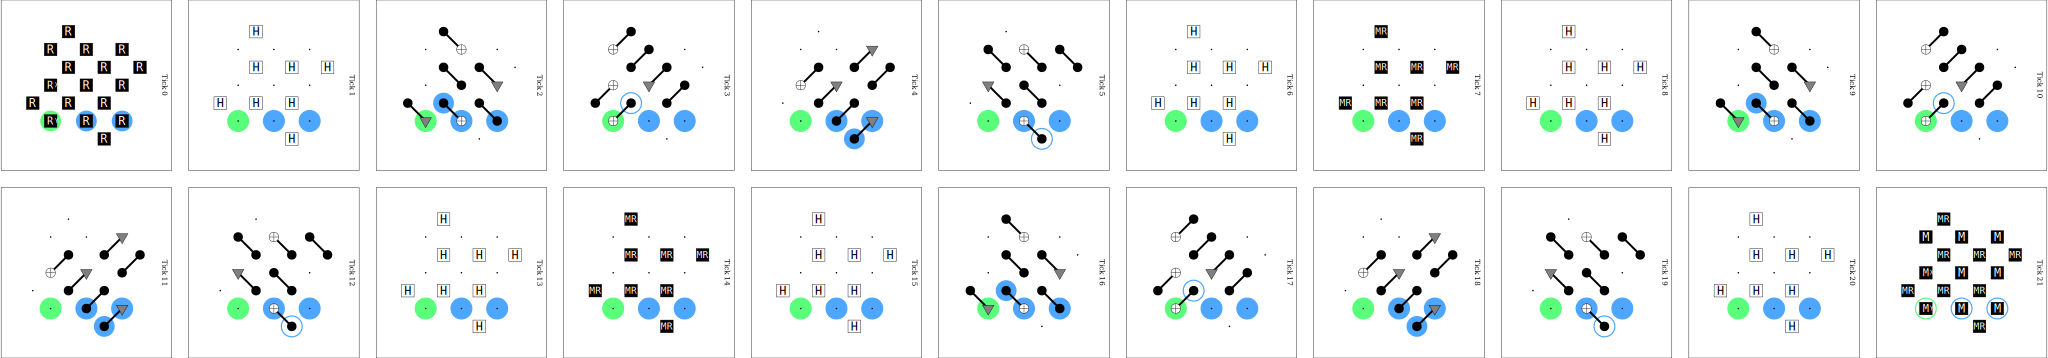

In [328]:
from io import StringIO

def build_circuit(data_loc, syndrome_loc, deformation, stabilizers, connection_order, logicals, basis_z, rounds):
    initial = StringIO()
    internal = StringIO()
    final = StringIO()

    # Qubit coordinates
    for i, loc in enumerate(data_loc):
        initial.write(f"QUBIT_COORDS({loc[0]},{loc[1]}) {i}\n")
    for i, loc in enumerate(syndrome_loc):
        initial.write(f"QUBIT_COORDS({loc[0]},{loc[1]}) {i + num_dat}\n")

    # Reset section
    for i in range(num_dat):
        initial.write(f"R{basis[int(basis_z)][deformation[i]]} {i}\n")
    for i in range(num_syn):
        initial.write(f"R {i + num_dat}\n")

    # Measurement start
    initial.write("TICK[1q]\n")
    internal.write("TICK[1q]\n")
    for i in range(num_syn):
        initial.write(f"H {i + num_dat}\n")
        internal.write(f"H {i + num_dat}\n")

    # 2q measurements
    for i in range(4):
        initial.write("TICK[2q]\n")
        internal.write("TICK[2q]\n")
        for c, t in connection_order[i]:
            gate = stab_gates[stabilizers[c, t]][stabilizers[c, t + num_dat]]
            initial.write(f"{gate} {c + num_dat} {t}\n")
            internal.write(f"{gate} {c + num_dat} {t}\n")

    # Measurement ends
    initial.write("TICK[1q]\n")
    internal.write("TICK[1q]\n")
    for i in range(num_syn):
        initial.write(f"H {i + num_dat}\n")
        internal.write(f"H {i + num_dat}\n")
    initial.write("TICK[1q]\n")
    internal.write("TICK[1q]\n")
    for i in range(num_syn):
        initial.write(f"MR {i + num_dat}\n")
        internal.write(f"MR {i + num_dat}\n")

    # Data qubit measurements
    for i in range(num_dat):
        final.write(f"M{basis[int(basis_z)][deformation[i]]} {i}\n")
    
    # Detector definitions
    for i in range(num_syn):
        internal.write(f"DETECTOR rec[-{num_syn - i}] rec[-{2*num_syn - i}]\n")
    for i, (sx, sy) in enumerate(syndrome_loc):
        if (i >= num_stab // 2 and not basis_z) or (i < num_stab // 2 and basis_z):
            initial.write(f"DETECTOR rec[-{num_syn - i}]\n")
            final.write(f"DETECTOR rec[-{num_dat + num_syn - i}]")
            for j, (dx, dy) in enumerate(data_loc):
                if abs(sx - dx) + abs(sy - dy) == 1:
                    # data qubit j is num_dat - j measurements before the end
                    final.write(f" rec[-{num_dat - j}]")
            final.write("\n")
    
    # Logical observable definition
    final.write("OBSERVABLE_INCLUDE(0)")
    for i, (lx, lz) in enumerate(logicals[int(basis_z)].reshape(2,-1).T):
        if lx + lz != 0: 
            final.write(f" rec[-{num_dat - i}]")
    final.write("\n")

    # return stim.Circuit(initial.getvalue())
    return stim.Circuit(initial.getvalue() + f"REPEAT {rounds - 1} {{{internal.getvalue()}}}" + final.getvalue())

num_stab = distance**2 - 1  # Number of stabilizers in each round

# In the first round only halve the stabilizers are measured as the other halve are not yet deterministic (Can you see why?)
initialization_stabilizers = [f"D{i}" for i in range(num_stab // 2)]  # First round stabilizers [D0, D1, D2, D3]

# The stabilizers measured for a single round of stabilizer measurements - you may notice that they actually span two rounds (Why do you think that is?)
round_n = 2 # Change this to see stabilizers from different rounds (0-indexed)
round_n_stabilizers = [f"D{i + int((round_n + 1/2) * num_stab)}" for i in range(num_stab)]

build_circuit(
    data_loc, syndrome_loc, deformation, stabilizers, connection_order, logicals, basis_z=True, rounds=3
).diagram("detslice-with-ops-svg", rows=2, filter_coords=["L0"])

In [332]:
%%timeit
build_circuit(
    data_loc, syndrome_loc, deformation, stabilizers, connection_order, logicals, basis_z=True, rounds=3
)

4.62 ms ± 99.5 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [333]:
%%timeit
stim.Circuit.generated("surface_code:rotated_memory_z", distance=distance, rounds=3)

45.4 μs ± 3.16 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [331]:
%%timeit
build_stim_circuit(code, deformation, rounds=3, basis="+Z")

12.1 ms ± 574 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
